# Music Generation using Algorithmic Approch
I utilized a modified version of the 16x16 tone matrix concept to generate music. Specifically, I processed an image and used it as a switch to activate specific elements in the tone matrix.

Reference for tone matrix: https://tonematrix.maxlaumeister.com/

In [1]:
# to play the midi file in nootebook
!pip install midi-player -q

## Import Dependencies

- The **OpenCV** library is used for image manipulation: [OpenCV on PyPI](https://pypi.org/project/opencv-python/)
- The **Music21** library is implemented for processing symbolic music representations: [Music21 on PyPI](https://pypi.org/project/music21/)
- **NumPy** is utilized for performing array and matrix operations: [NumPy on PyPI](https://pypi.org/project/numpy/)
- The **Matplotlib** library is incorporated for displaying and saving high-quality images in various dimensions: [Matplotlib on PyPI](https://pypi.org/project/matplotlib/)

In [2]:
import cv2
import numpy as np
import music21 as m21
import matplotlib.pyplot as plt

In [3]:
SEQ_LEN = 32
IMAGE_PATH = './../images/Warren-Buffett-On-Rules.jpg'

In [4]:
# Load the image
img = cv2.imread(IMAGE_PATH)

# Resize the image to 16x16 pixels
resized_img = cv2.resize(img, (SEQ_LEN, 16))

# Convert the image to grayscale
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

# for working with different color scale, split image into b, g, r separately
b, r, g = cv2.split(resized_img)
print(f"Shape of one space image: {b.shape}")

Shape of one space image: (16, 32)


## Extracting intensity information column-wise
The algorithm extracts the intensity information from the image column-wise. For each column, it calculates either the maximum intensity or the minimum intensity value according to user choice.

In [5]:
def get_intensity_columnwise(resized_img, seq_len=16, approach='max'):
    """
    Get the intensity values of the resized image.

    Args:
        resized_img: numpy array
            The resized image as a 2D array with only one color scale.
        seq_len: int, optional (default: 16)
            The length of the generated music sequence. The width of the image is divided into this many segments.
        approach: str, optional (default: 'max')
            The approach to use when mapping pixel intensity to musical notes. 'max' uses the maximum pixel intensity,
            while 'average' uses the average intensity.

    Returns:
        column_index: list
            A list of the indices of the maximum (or average) intensity value in each column of the image.
    """
    if approach not in ['max', 'min']:
        raise ValueError("The 'approach' argument must be either 'max' or 'min'.")
    
    intensity_values = resized_img.flatten()
    print(f'Shape of intensity_values: {intensity_values.shape} and resized image_shape: {resized_img.shape}')

    # Transpose the intensity values to get the values column-wise
    intensity_values_column_wise = [intensity_values[i::seq_len] for i in range(seq_len)]

    column_index = []
    
    # Print the index of the intensity values column-wise
    for i, col in enumerate(intensity_values_column_wise):
        # print(f'Index: {i} and Length of col: {len(col)}')
        if approach == 'max':
            indices = np.where(col == col.max())[0].tolist()
        elif approach == 'min':
            indices = np.where(col == col.min())[0].tolist()
        column_index.append(indices)
        # print(f'Column {i}: {col} and maxindex: {indices}')
    return column_index

In [6]:
max_intensity_list = get_intensity_columnwise(b, seq_len=SEQ_LEN)
# min_intensity_list = get_intensity_columnwise(b, seq_len=16, approach='min')

Shape of intensity_values: (512,) and resized image_shape: (16, 32)


## Plot images with separate color space

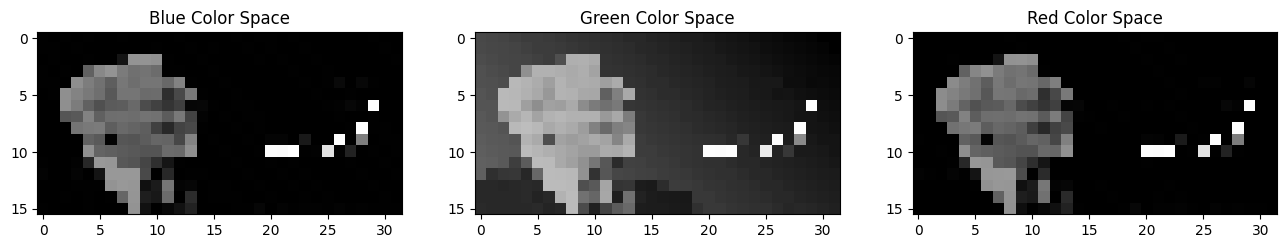

In [7]:
plt.figure(figsize=(16,SEQ_LEN))
images_color_space = (b, g, r)
image_label = ['Blue', 'Green', 'Red']
for index in range(3):
    plt.subplot(1, 3, index+1)
    plt.title(f"{image_label[index]} Color Space")
    plt.imshow(images_color_space[index], cmap='gray')
plt.show()

## Tone matrix Configuration
The Tone matrix is a 2D matrix where the horizontal axis represents time and the vertical axis represents frequency. As we move from bottom to top on the vertical axis, the frequency increases. Similarly, as we move from left to right on the horizontal axis, time increases. The matrix consists of 16 fixed notes, where each note is assigned a unique row ranging from the lower frequency note C3 to the upper frequency note C6.
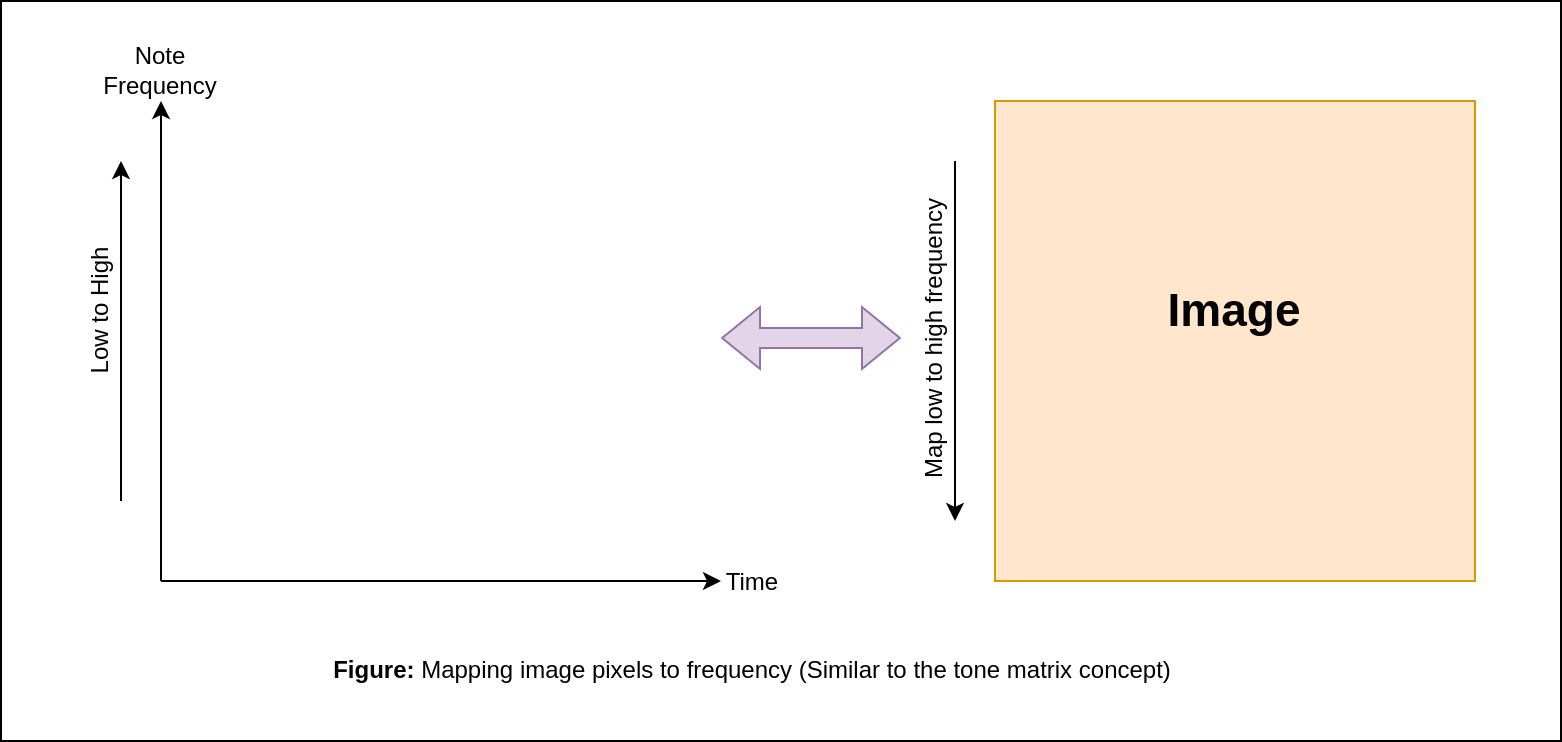

In [8]:
# make 16x16 tone matrix
switch = np.zeros((16, SEQ_LEN), dtype='object')
notes = ['C6', 'A5', 'G5', 'F5', 'D5', 'C5', 'A4', 'G4',
        'F4', 'D4', 'C4', 'A3', 'G3', 'F3', 'D3', 'C3']

for i in range(16):
  switch[i, :] = notes[i]
print(f"Tone matrix shape: {switch.shape}")

Tone matrix shape: (16, 32)


## Construct Switch configuration
If there are more switches that are to be opened in column-wise, then switch with least frequency is played. Here, column with highest index has lowest frequency

The pure black and white image is constructed by interchanging rows and columns for easier calculation. It has dimension Nx16. To get image with dimension equal to tone matrix, we transpose the array to get dimension 16xN. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def construct_switch_config(intensity, seq_len=16, config='s'):
    '''
    Constructs a binary image based on the given intensity values and configuration.

    Args:
        intensity: np.array or list -> A list containing a list of intensity indices.
        seq_len: int -> The length of the time axis. Default value is 16.
        config: str -> Configuration for the switch matrix. Possible values are:
                's' (single): Only one note can be activated in a column at a time.
                'two': A maximum of two notes can be played at a time.
                'three': A maximum of three notes can be played at a time.
                'all': No limit to the number of notes that can be played at a time.

    Returns:
        bw_image: np.array -> A 2D array representing the binary image where 255 represents the ON state 
                              and 0 represents the OFF state.
    '''
    bw_image = np.zeros((seq_len, 16), dtype='uint8')

    for i, index_col in enumerate(intensity):
        if config.lower() in ['s', 'single']:
            if index_col:
                bw_image[i, index_col[-1]] = 255

        elif config.lower() == 'two':
            if index_col:
                print(index_col)
                bw_image[i, index_col[-1]] = 255
                if len(index_col) > 1:
                    bw_image[i, index_col[-2]] = 255

        elif config.lower() == 'all':
            bw_image[i, index_col] = 255

    return bw_image.T  # Transpose to get the desired orientation

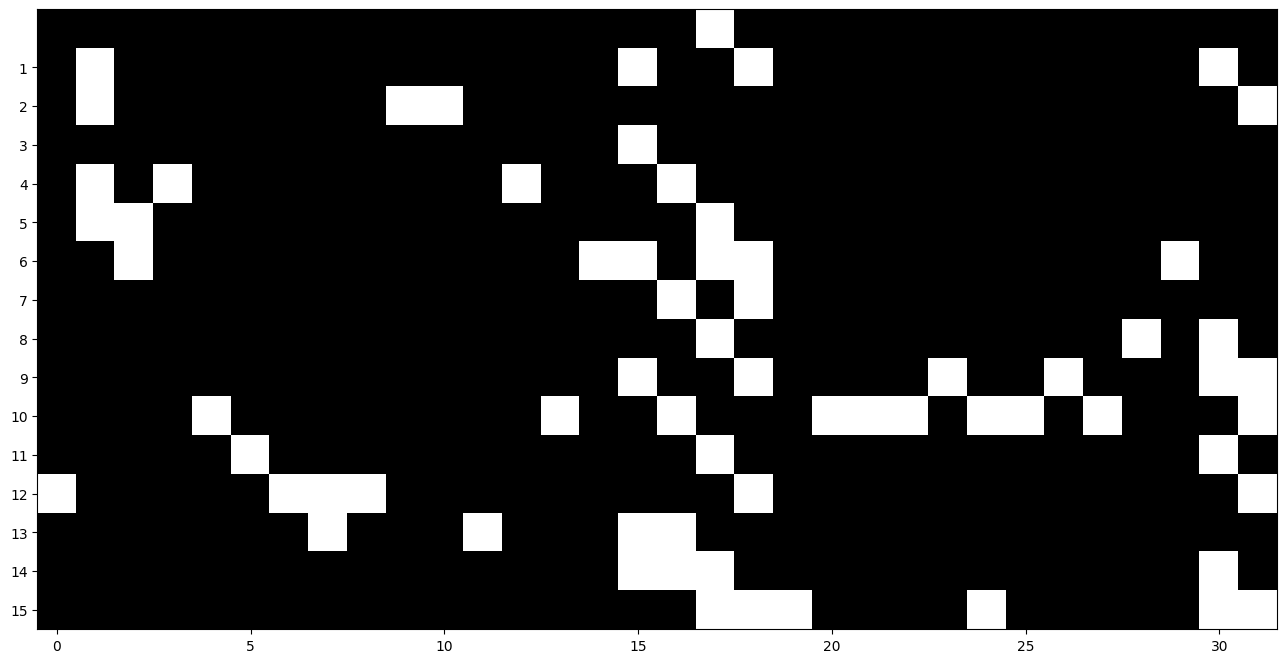

In [10]:
bw_image = construct_switch_config(max_intensity_list, seq_len=SEQ_LEN, config='all')
plt.figure(figsize=(16, 16))
plt.imshow(bw_image, cmap='gray')
plt.yticks(range(1, 16))
# plt.axis('off')
plt.show()

## Creating melody
The tone matrix is configured with a switch setting (black and white) to produce the melody.

In [11]:
def construct_melody(image, tone_matrix, instrument='Piano', seq_len=16):
    """
    Generate a Music21 Stream object.

    Args:
        image: numpy array or list, shape (16, seq_len)
            The image that serves as the basis for the melody.
        tone_matrix: numpy array or list, shape (16, seq_len)
            The tone matrix that corresponds to the image.
        instrument: str, optional (default: 'Piano')
            The instrument to use when creating the melody.
        seq_len: int, optional (default: 16)
            The length of the melody, in number of notes.

    Returns:
        A Music21 Stream object representing the generated melody.
    """
    stream_algo = m21.stream.Stream()
    instrument_obj = m21.instrument.fromString(instrument)
    stream_algo.insert(0.0, instrument_obj)
    offset = 0.0
    
    for y in range(seq_len):
        notes_to_add = []
        for x in range(16):
            if image[x][y] != 0:
                notes_to_add.append(tone_matrix[x][y])
        
        if notes_to_add:
            chord_or_note = m21.chord.Chord(notes_to_add) if len(notes_to_add) > 1 else m21.note.Note(notes_to_add[0])
            stream_algo.insert(offset, chord_or_note)
            # print(f"Inserted {'Chord' if len(notes_to_add) > 1 else 'Note'}: {notes_to_add} at offset {offset}")

        offset += 0.5 if len(notes_to_add) == 1 else 1.0
    
    return stream_algo

### Save in midi format

In [12]:
MIDI_OUTPUT_FILE = 'music_tone_matrix.mid'
stream_algo = construct_melody(image=bw_image, tone_matrix=switch, seq_len=SEQ_LEN)

# stream_algo.show('text')
stream_algo.write('midi', MIDI_OUTPUT_FILE)

'music_tone_matrix.mid'

In [13]:
from midi_player import MIDIPlayer
from midi_player.stylers import basic, cifka_advanced

midi_file = 'music_tone_matrix.mid'

MIDIPlayer(midi_file, 160, styler=cifka_advanced, title='My Player')